In [1]:
import pandas as pd
import  duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

%load_ext autoreload
from duckdb_flow.etl import preprocess_data, get_processed_files
from duckdb_flow.create_database import create_database

The autoreload module is not an IPython extension.


In [2]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

In [3]:
create_database()

'Database Created'

In [4]:
processed_files = get_processed_files()
movies_df, directing_data, writing_data  = preprocess_data(processed_files)

Created  directing_df  dataframe.
Appending:  963  rows...
Appending:  993  rows...
Appending:  951  rows...
Appending:  1049  rows...
Appending:  974  rows...
Appending:  1001  rows...
Appending:  1035  rows...
Appending:  993  rows...
Created  writing_df  dataframe.


In [5]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

## EDA

### Movies

In [5]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
movies = con.execute('''select * from movies''').fetch_df()
movies.shape
con.close()

In [11]:
con.dtype

<bound method PyCapsule.dtype of <duckdb.duckdb.DuckDBPyConnection object at 0x000001575ACC2F30>>

In [7]:
movies[movies["original_title"]=="nan"]

,movie_id,primary_title,original_title,start_year,runtime_min,num_votes,label,subset,title_changed,title_length,audit_time
6,tt0021015,juno and the paycock,nan,1929,85,2275,False,train,True,20,2024-03-08 16:47:30.585
7,tt0023973,the eagle and the hawk,nan,1933,73,3526,True,train,True,22,2024-03-08 16:47:30.585
8,tt0023986,employees entrance,nan,1933,75,3526,True,train,True,19,2024-03-08 16:47:30.585
11,tt0025028,dames,nan,1934,91,2038,True,train,True,5,2024-03-08 16:47:30.585
13,tt0028333,swing time,nan,1936,103,3526,True,train,True,10,2024-03-08 16:47:30.585
...,...,...,...,...,...,...,...,...,...,...,...
9993,tt9207700,made in italy,nan,2020,94,7053,NaN,test,True,13,2024-03-08 16:47:30.585
9994,tt9316022,struggle the life and lost art of szukalski,nan,2018,115,3526,NaN,test,True,44,2024-03-08 16:47:30.585
9995,tt9430698,one piece stampede,nan,2019,101,5109,NaN,test,True,19,2024-03-08 16:47:30.585
9996,tt9441638,the big ugly,nan,2020,106,5780,NaN,test,True,12,2024-03-08 16:47:30.585


In [14]:
movies.subset.value_counts()

subset
train    7959
test     1086
val       955
Name: count, dtype: int64

In [7]:
test = movies[movies["label"].isna()]

for col in test.columns:
    print(str(col), test[col].isna().sum())

movie_id 0
primary_title 0
original_title 0
start_year 0
runtime_min 0
num_votes 0
label 2041
subset 0
title_changed 0
title_length 0
audit_time 0


In [12]:
test["num_votes"].value_counts()

num_votes
3526     210
1068       5
1430       4
1221       4
1677       4
        ... 
4350       1
1784       1
25664      1
1100       1
5271       1
Name: count, Length: 1621, dtype: int64

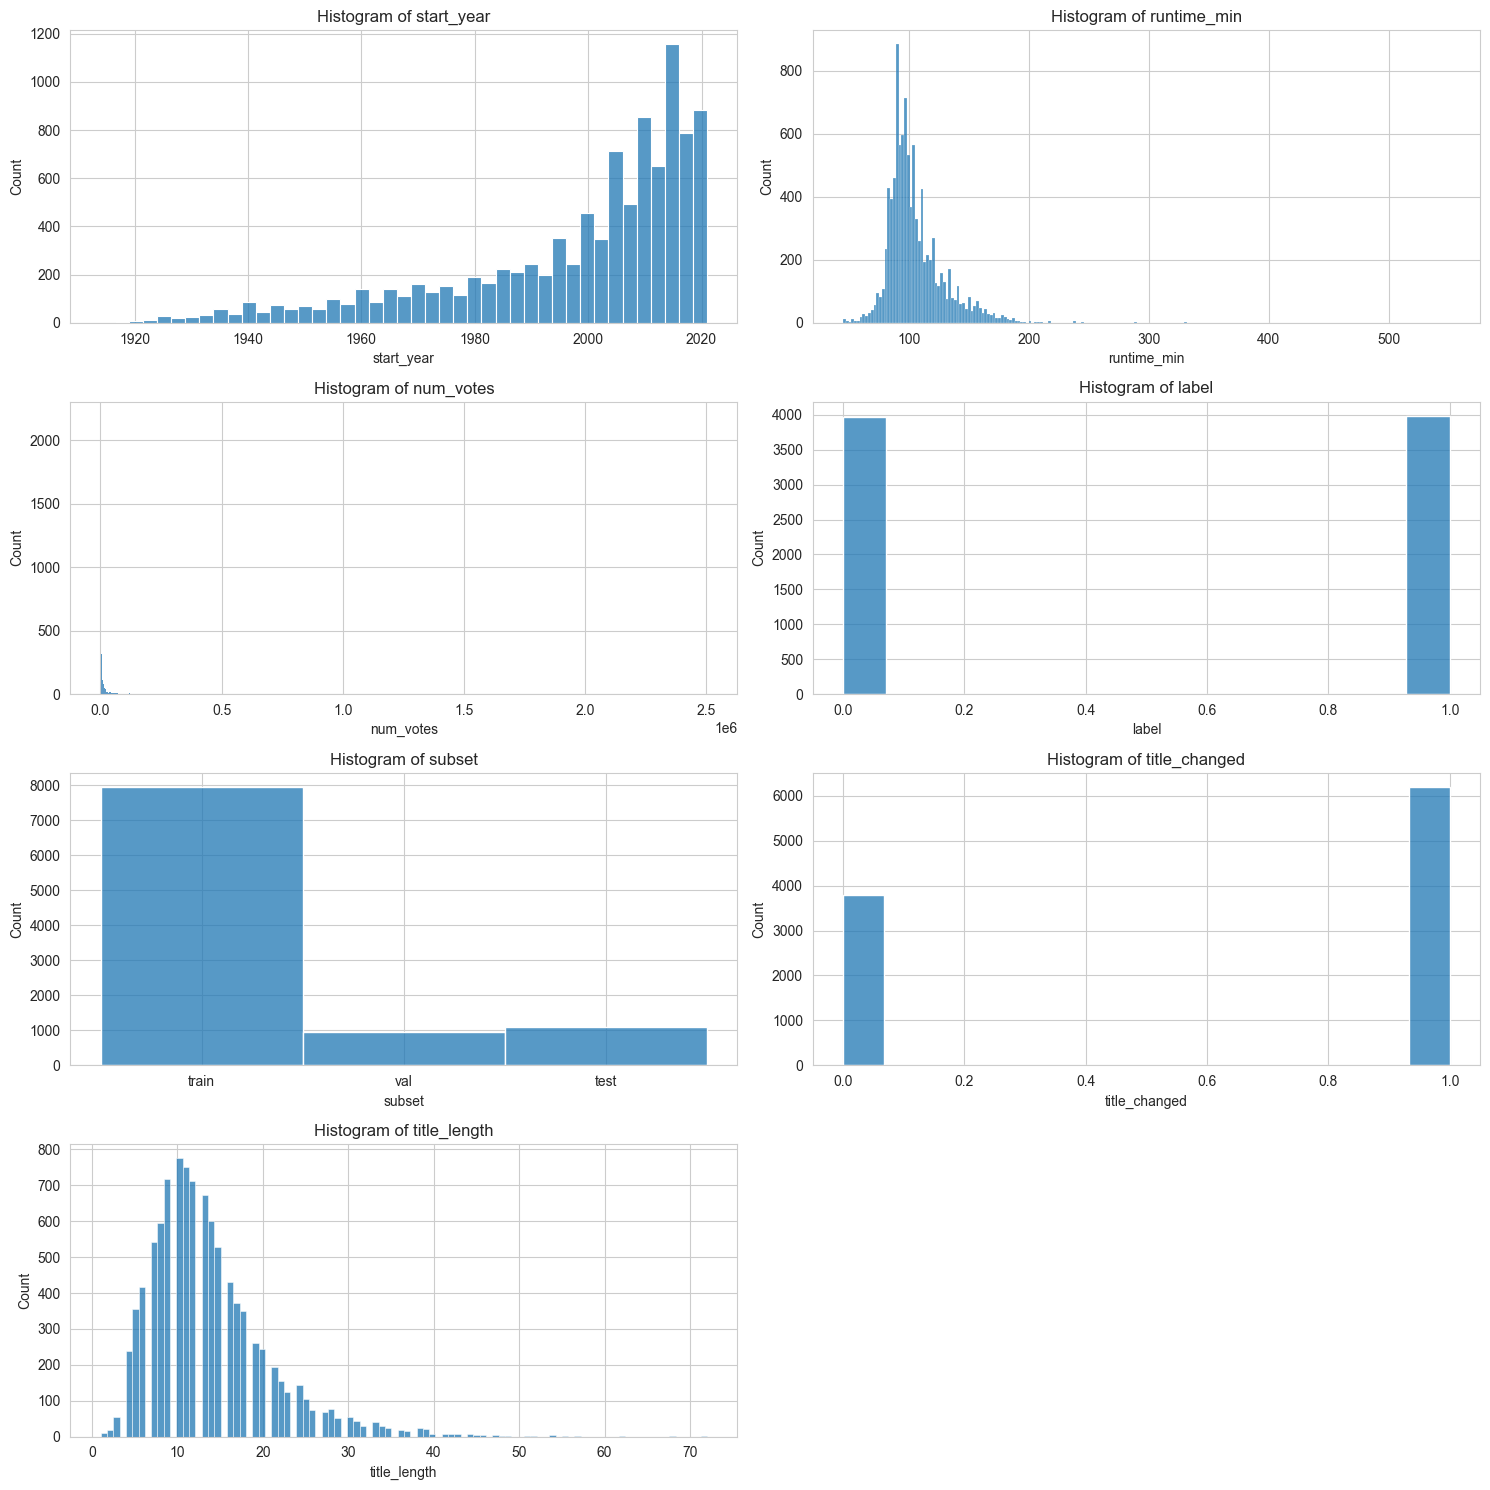

In [13]:
movie_cols = ['start_year', 'runtime_min', 'num_votes', 'label', 'subset', "title_changed", "title_length"]
num_cols = len(movie_cols)
num_rows = (num_cols + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 15))

axes = axes.flatten()

for i, column in enumerate(movie_cols):
    if column == 'num_votes':
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')
    else:
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

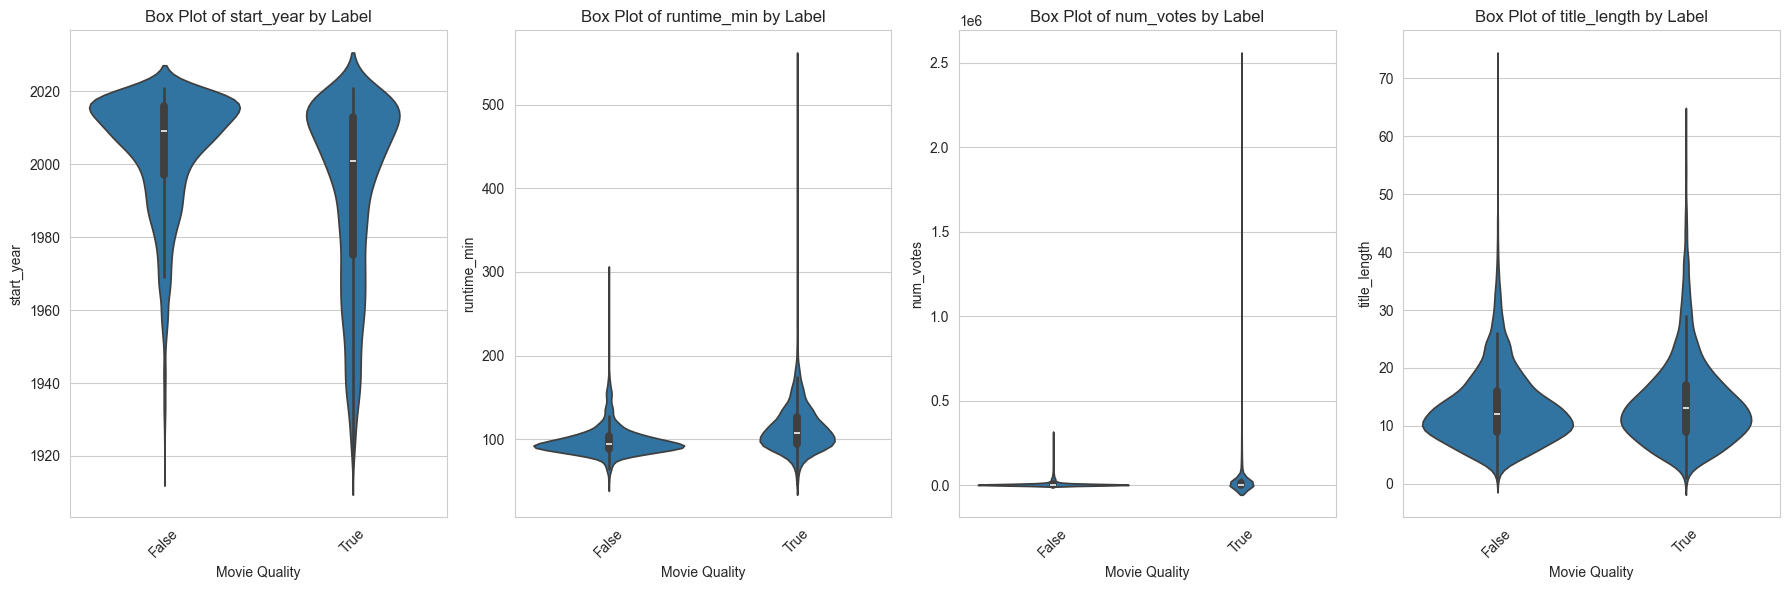

In [11]:

continuous_variables = ['start_year', 'runtime_min', 'num_votes', "title_length"]

fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, variable in enumerate(continuous_variables):
    sns.violinplot(x='label', y=variable, data=movies, ax=axes[i])
    axes[i].set_title(f'Box Plot of {variable} by Label')
    axes[i].set_xlabel('Movie Quality')
    axes[i].set_ylabel(variable)
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

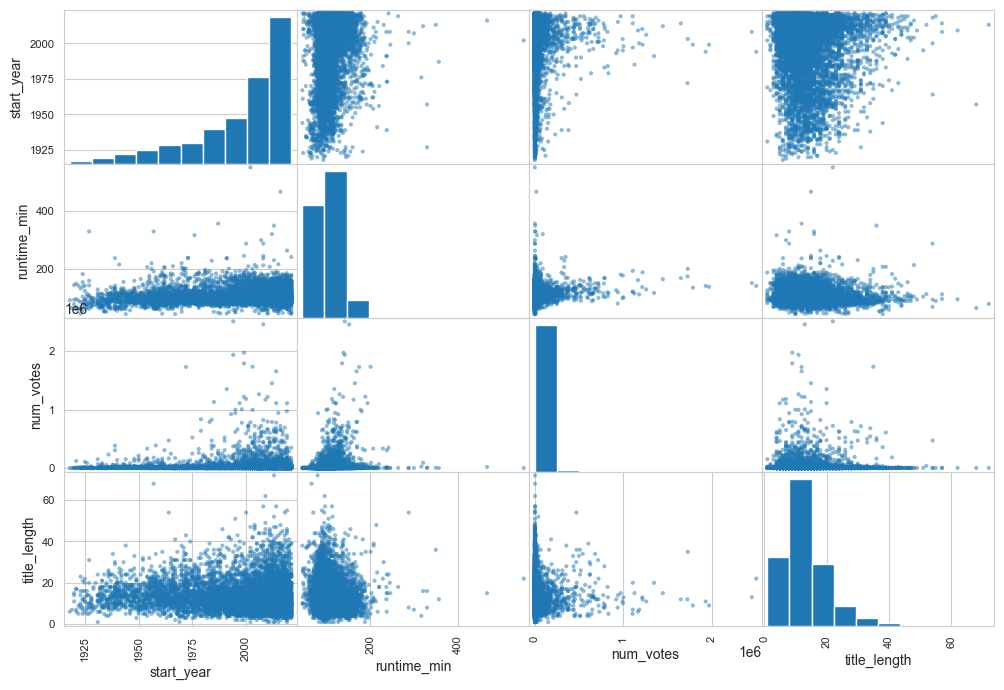

In [16]:
from pandas.plotting import scatter_matrix

scatter_matrix(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes', "title_length"]], figsize=(12, 8))
plt.show()

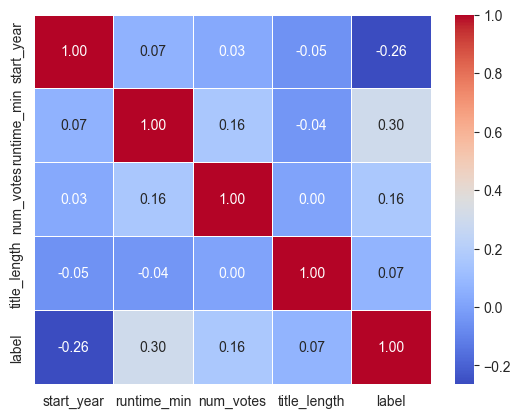

In [17]:
sns.heatmap(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes',"title_length", 'label']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

### Directors

In [13]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
directing = con.execute('''select * from directing''').fetch_df()
directing.shape
con.close()

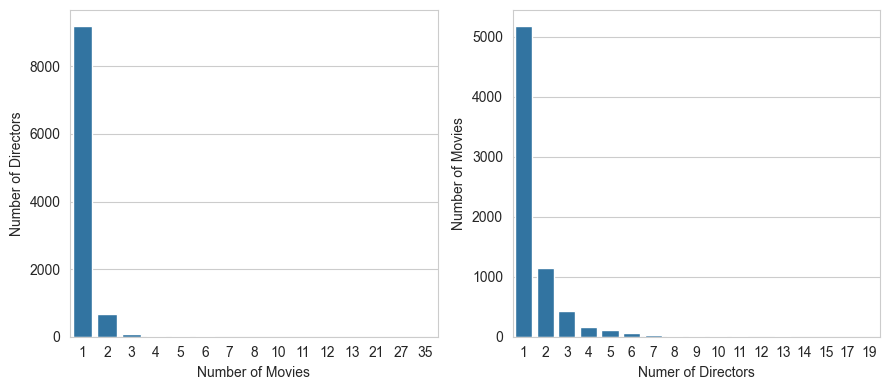

In [40]:
# Counting the number of directors per movie
director_counts = directing.groupby("movie_id").count()["director_id"].value_counts()
# Counting the number of movies directed by each director
movie_counts = directing.groupby("director_id").count()["movie_id"].value_counts()

# Creating a figure with two subplots
plt.figure(figsize=(9, 4))  

# Subplot 1: Distribution of movies directed by directors
plt.subplot(1, 2, 1)
sns.barplot(x=director_counts.index, y=director_counts.values)
plt.xlabel("Number of Movies")
plt.ylabel("Number of Directors")

plt.subplot(1, 2, 2)
sns.barplot(x=movie_counts.index, y=movie_counts.values)
plt.xlabel("Numer of Directors")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

### Writers

In [15]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
writing = con.execute('''select * from writing''').fetch_df()
writing.shape
con.close()

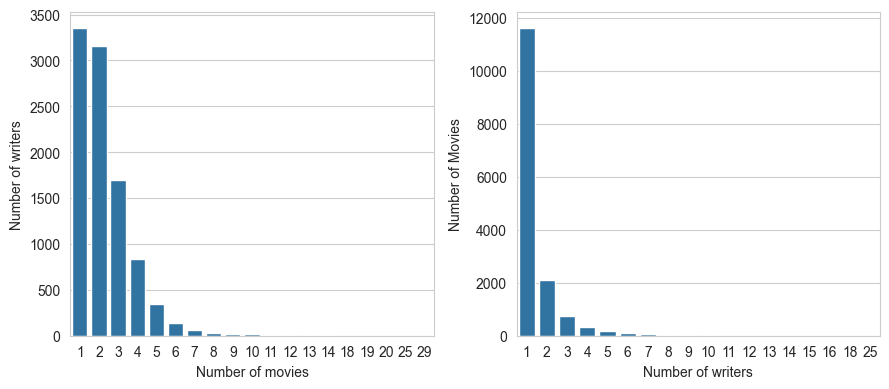

In [38]:
# Counting the number of writers per movie
writer_counts = writing.groupby("movie_id").count()["writer_id"].value_counts()
# Counting the number of movies writen per writer
movie_counts = writing.groupby("writer_id").count()["movie_id"].value_counts()

plt.figure(figsize=(9, 4))  
plt.subplot(1, 2, 1)
sns.barplot(x=writer_counts.index, y=writer_counts.values)
plt.xlabel("Number of movies")
plt.ylabel("Number of writers")

plt.subplot(1, 2, 2)
sns.barplot(x=movie_counts.index, y=movie_counts.values)
plt.xlabel("Number of writers")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()